# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

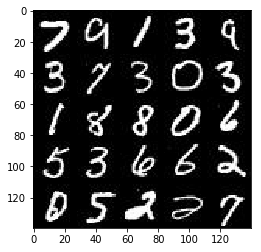

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

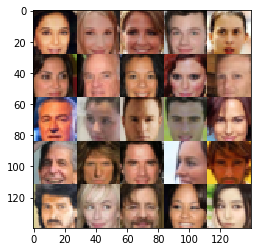

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        shape = relu3.get_shape()
        
        
        flat = tf.reshape(relu3, [-1, int(shape[1]*shape[2]*shape[3])])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        fc1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(fc1, [-1, 7, 7, 512])
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 20... Discriminator Loss: 2.9514... Generator Loss: 0.1072
Epoch 1/2... Step 40... Discriminator Loss: 2.3820... Generator Loss: 0.6084
Epoch 1/2... Step 60... Discriminator Loss: 1.8234... Generator Loss: 0.5085
Epoch 1/2... Step 80... Discriminator Loss: 1.4595... Generator Loss: 0.6097
Epoch 1/2... Step 100... Discriminator Loss: 1.7498... Generator Loss: 0.6097


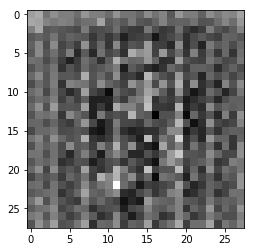

Epoch 1/2... Step 120... Discriminator Loss: 1.6725... Generator Loss: 0.2780
Epoch 1/2... Step 140... Discriminator Loss: 1.1818... Generator Loss: 1.0895
Epoch 1/2... Step 160... Discriminator Loss: 1.2749... Generator Loss: 0.5277
Epoch 1/2... Step 180... Discriminator Loss: 1.2159... Generator Loss: 1.2340
Epoch 1/2... Step 200... Discriminator Loss: 1.1515... Generator Loss: 1.6772


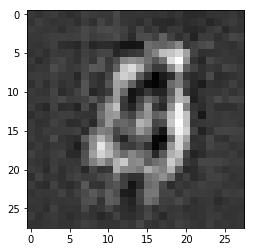

Epoch 1/2... Step 220... Discriminator Loss: 1.0068... Generator Loss: 1.0863
Epoch 1/2... Step 240... Discriminator Loss: 1.4221... Generator Loss: 0.3879
Epoch 1/2... Step 260... Discriminator Loss: 0.8834... Generator Loss: 0.9533
Epoch 1/2... Step 280... Discriminator Loss: 1.0196... Generator Loss: 0.7810
Epoch 1/2... Step 300... Discriminator Loss: 1.3184... Generator Loss: 0.4041


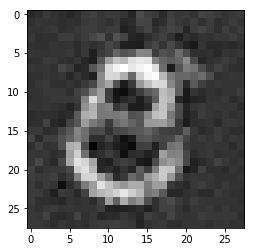

Epoch 1/2... Step 320... Discriminator Loss: 2.2340... Generator Loss: 0.1302
Epoch 1/2... Step 340... Discriminator Loss: 0.9537... Generator Loss: 0.9255
Epoch 1/2... Step 360... Discriminator Loss: 1.3028... Generator Loss: 0.4293
Epoch 1/2... Step 380... Discriminator Loss: 0.5200... Generator Loss: 1.8239
Epoch 1/2... Step 400... Discriminator Loss: 1.2665... Generator Loss: 0.4107


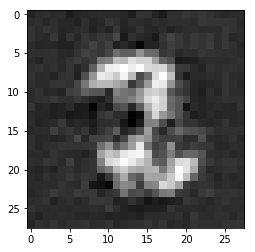

Epoch 1/2... Step 420... Discriminator Loss: 0.3753... Generator Loss: 2.0735
Epoch 1/2... Step 440... Discriminator Loss: 2.6770... Generator Loss: 1.6236
Epoch 1/2... Step 460... Discriminator Loss: 0.9244... Generator Loss: 0.7080
Epoch 1/2... Step 480... Discriminator Loss: 0.3485... Generator Loss: 3.1300
Epoch 1/2... Step 500... Discriminator Loss: 1.1000... Generator Loss: 0.5228


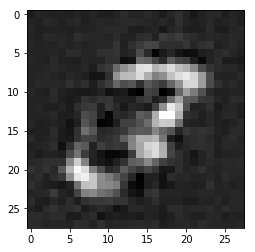

Epoch 1/2... Step 520... Discriminator Loss: 1.4758... Generator Loss: 0.3378
Epoch 1/2... Step 540... Discriminator Loss: 0.6018... Generator Loss: 1.0717
Epoch 1/2... Step 560... Discriminator Loss: 1.2738... Generator Loss: 0.4282
Epoch 1/2... Step 580... Discriminator Loss: 0.5708... Generator Loss: 1.0009
Epoch 1/2... Step 600... Discriminator Loss: 0.2933... Generator Loss: 2.0914


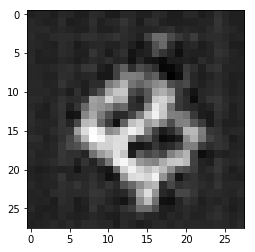

Epoch 1/2... Step 620... Discriminator Loss: 1.0600... Generator Loss: 0.5355
Epoch 1/2... Step 640... Discriminator Loss: 0.8738... Generator Loss: 0.7656
Epoch 1/2... Step 660... Discriminator Loss: 0.7431... Generator Loss: 0.8712
Epoch 1/2... Step 680... Discriminator Loss: 2.1336... Generator Loss: 0.1571
Epoch 1/2... Step 700... Discriminator Loss: 0.6742... Generator Loss: 0.9768


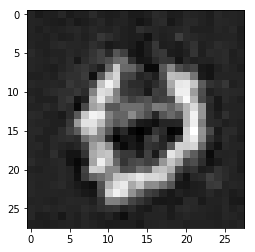

Epoch 1/2... Step 720... Discriminator Loss: 0.7558... Generator Loss: 0.7673
Epoch 1/2... Step 740... Discriminator Loss: 0.3252... Generator Loss: 1.8033
Epoch 1/2... Step 760... Discriminator Loss: 0.4800... Generator Loss: 1.3344
Epoch 1/2... Step 780... Discriminator Loss: 1.3826... Generator Loss: 0.3627
Epoch 1/2... Step 800... Discriminator Loss: 0.6993... Generator Loss: 0.8964


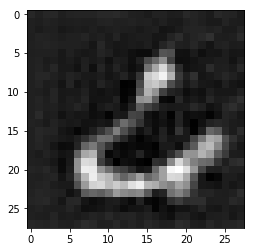

Epoch 1/2... Step 820... Discriminator Loss: 0.9665... Generator Loss: 0.6886
Epoch 1/2... Step 840... Discriminator Loss: 0.2261... Generator Loss: 2.4194
Epoch 1/2... Step 860... Discriminator Loss: 0.6503... Generator Loss: 0.9409
Epoch 1/2... Step 880... Discriminator Loss: 1.1254... Generator Loss: 0.5171
Epoch 1/2... Step 900... Discriminator Loss: 0.1397... Generator Loss: 4.2666


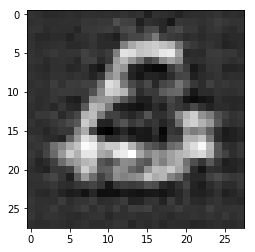

Epoch 1/2... Step 920... Discriminator Loss: 0.6125... Generator Loss: 0.9692
Epoch 2/2... Step 3... Discriminator Loss: 0.5235... Generator Loss: 1.2020
Epoch 2/2... Step 23... Discriminator Loss: 0.8507... Generator Loss: 0.7481
Epoch 2/2... Step 43... Discriminator Loss: 0.6200... Generator Loss: 1.0317
Epoch 2/2... Step 63... Discriminator Loss: 1.3733... Generator Loss: 0.3576


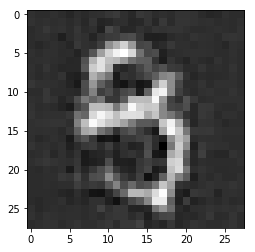

Epoch 2/2... Step 83... Discriminator Loss: 0.5018... Generator Loss: 1.1970
Epoch 2/2... Step 103... Discriminator Loss: 0.5082... Generator Loss: 1.1824
Epoch 2/2... Step 123... Discriminator Loss: 2.2353... Generator Loss: 0.1386
Epoch 2/2... Step 143... Discriminator Loss: 0.7684... Generator Loss: 0.9048
Epoch 2/2... Step 163... Discriminator Loss: 0.2694... Generator Loss: 4.0664


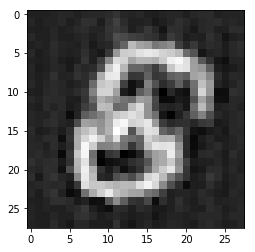

Epoch 2/2... Step 183... Discriminator Loss: 0.8151... Generator Loss: 0.7391
Epoch 2/2... Step 203... Discriminator Loss: 0.4155... Generator Loss: 1.4798
Epoch 2/2... Step 223... Discriminator Loss: 0.2311... Generator Loss: 2.2104
Epoch 2/2... Step 243... Discriminator Loss: 1.6501... Generator Loss: 0.2591
Epoch 2/2... Step 263... Discriminator Loss: 1.4478... Generator Loss: 0.3222


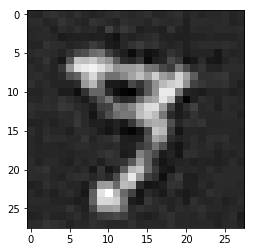

Epoch 2/2... Step 283... Discriminator Loss: 0.7638... Generator Loss: 0.7673
Epoch 2/2... Step 303... Discriminator Loss: 0.1901... Generator Loss: 2.3204
Epoch 2/2... Step 323... Discriminator Loss: 0.1630... Generator Loss: 3.6225
Epoch 2/2... Step 343... Discriminator Loss: 1.0336... Generator Loss: 0.5819
Epoch 2/2... Step 363... Discriminator Loss: 0.3031... Generator Loss: 2.4045


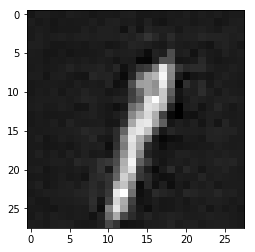

Epoch 2/2... Step 383... Discriminator Loss: 0.7014... Generator Loss: 1.5518
Epoch 2/2... Step 403... Discriminator Loss: 1.2631... Generator Loss: 0.4074
Epoch 2/2... Step 423... Discriminator Loss: 0.0980... Generator Loss: 4.7612
Epoch 2/2... Step 443... Discriminator Loss: 0.7816... Generator Loss: 1.8838
Epoch 2/2... Step 463... Discriminator Loss: 1.5955... Generator Loss: 0.2899


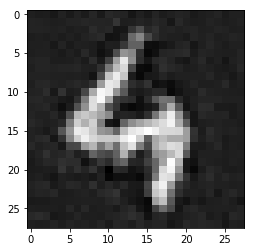

Epoch 2/2... Step 483... Discriminator Loss: 1.6141... Generator Loss: 0.3096
Epoch 2/2... Step 503... Discriminator Loss: 0.4872... Generator Loss: 1.1960
Epoch 2/2... Step 523... Discriminator Loss: 1.1539... Generator Loss: 0.6014
Epoch 2/2... Step 543... Discriminator Loss: 0.7668... Generator Loss: 0.8865
Epoch 2/2... Step 563... Discriminator Loss: 0.4144... Generator Loss: 1.3551


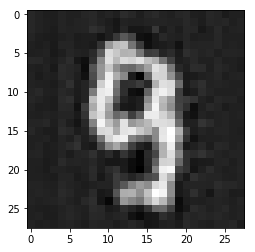

Epoch 2/2... Step 583... Discriminator Loss: 0.3147... Generator Loss: 1.5669
Epoch 2/2... Step 603... Discriminator Loss: 0.3539... Generator Loss: 1.5325
Epoch 2/2... Step 623... Discriminator Loss: 0.3229... Generator Loss: 1.9652
Epoch 2/2... Step 643... Discriminator Loss: 1.0047... Generator Loss: 0.5535
Epoch 2/2... Step 663... Discriminator Loss: 0.2160... Generator Loss: 2.2549


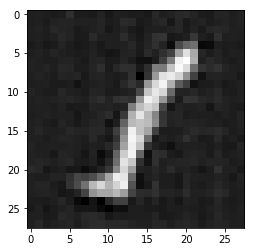

Epoch 2/2... Step 683... Discriminator Loss: 2.3758... Generator Loss: 0.1494
Epoch 2/2... Step 703... Discriminator Loss: 0.6151... Generator Loss: 1.9829
Epoch 2/2... Step 723... Discriminator Loss: 0.2766... Generator Loss: 1.7411
Epoch 2/2... Step 743... Discriminator Loss: 0.1356... Generator Loss: 2.6301
Epoch 2/2... Step 763... Discriminator Loss: 1.2848... Generator Loss: 0.3925


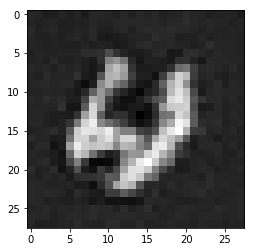

Epoch 2/2... Step 783... Discriminator Loss: 0.7662... Generator Loss: 0.8584
Epoch 2/2... Step 803... Discriminator Loss: 0.5697... Generator Loss: 1.0833
Epoch 2/2... Step 823... Discriminator Loss: 0.1049... Generator Loss: 2.7268
Epoch 2/2... Step 843... Discriminator Loss: 2.4219... Generator Loss: 0.1702
Epoch 2/2... Step 863... Discriminator Loss: 0.7667... Generator Loss: 1.0601


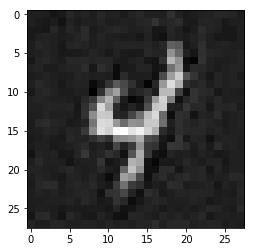

Epoch 2/2... Step 883... Discriminator Loss: 0.7179... Generator Loss: 2.0742
Epoch 2/2... Step 903... Discriminator Loss: 0.2890... Generator Loss: 2.4036
Epoch 2/2... Step 923... Discriminator Loss: 0.1294... Generator Loss: 4.1223


IndexError: list index out of range

In [52]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 20... Discriminator Loss: 4.3603... Generator Loss: 0.0473
Epoch 1/1... Step 40... Discriminator Loss: 2.7262... Generator Loss: 0.3914
Epoch 1/1... Step 60... Discriminator Loss: 2.8226... Generator Loss: 0.1843
Epoch 1/1... Step 80... Discriminator Loss: 2.1960... Generator Loss: 0.3500
Epoch 1/1... Step 100... Discriminator Loss: 1.9179... Generator Loss: 0.4099


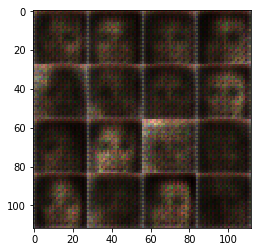

Epoch 1/1... Step 120... Discriminator Loss: 1.7795... Generator Loss: 0.4606
Epoch 1/1... Step 140... Discriminator Loss: 1.6428... Generator Loss: 0.4720
Epoch 1/1... Step 160... Discriminator Loss: 1.8639... Generator Loss: 0.4045
Epoch 1/1... Step 180... Discriminator Loss: 1.7088... Generator Loss: 0.4854
Epoch 1/1... Step 200... Discriminator Loss: 1.6682... Generator Loss: 0.4182


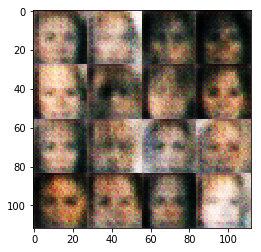

Epoch 1/1... Step 220... Discriminator Loss: 1.7032... Generator Loss: 0.5221
Epoch 1/1... Step 240... Discriminator Loss: 1.7036... Generator Loss: 0.4837
Epoch 1/1... Step 260... Discriminator Loss: 1.4969... Generator Loss: 0.5424
Epoch 1/1... Step 280... Discriminator Loss: 1.7499... Generator Loss: 0.5267
Epoch 1/1... Step 300... Discriminator Loss: 1.6362... Generator Loss: 0.5411


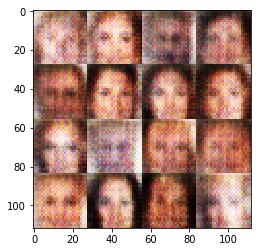

Epoch 1/1... Step 320... Discriminator Loss: 1.5831... Generator Loss: 0.5136
Epoch 1/1... Step 340... Discriminator Loss: 1.5054... Generator Loss: 0.6337
Epoch 1/1... Step 360... Discriminator Loss: 1.5440... Generator Loss: 0.5622
Epoch 1/1... Step 380... Discriminator Loss: 1.6461... Generator Loss: 0.5600
Epoch 1/1... Step 400... Discriminator Loss: 1.5090... Generator Loss: 0.5585


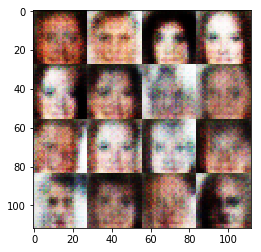

Epoch 1/1... Step 420... Discriminator Loss: 1.5724... Generator Loss: 0.5560
Epoch 1/1... Step 440... Discriminator Loss: 1.6460... Generator Loss: 0.6007
Epoch 1/1... Step 460... Discriminator Loss: 1.4955... Generator Loss: 0.6153
Epoch 1/1... Step 480... Discriminator Loss: 1.6018... Generator Loss: 0.5510
Epoch 1/1... Step 500... Discriminator Loss: 1.5873... Generator Loss: 0.5596


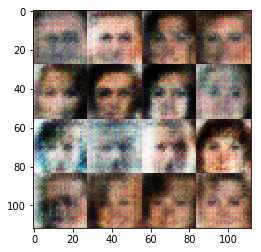

Epoch 1/1... Step 520... Discriminator Loss: 1.6354... Generator Loss: 0.5042
Epoch 1/1... Step 540... Discriminator Loss: 1.5314... Generator Loss: 0.5551
Epoch 1/1... Step 560... Discriminator Loss: 1.4549... Generator Loss: 0.6226
Epoch 1/1... Step 580... Discriminator Loss: 1.4881... Generator Loss: 0.6304
Epoch 1/1... Step 600... Discriminator Loss: 1.5840... Generator Loss: 0.5745


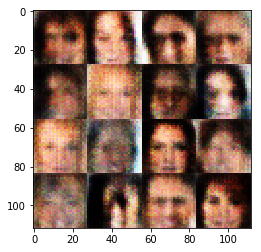

Epoch 1/1... Step 620... Discriminator Loss: 1.5152... Generator Loss: 0.5982
Epoch 1/1... Step 640... Discriminator Loss: 1.5427... Generator Loss: 0.5262
Epoch 1/1... Step 660... Discriminator Loss: 1.7013... Generator Loss: 0.5417
Epoch 1/1... Step 680... Discriminator Loss: 1.5051... Generator Loss: 0.6213
Epoch 1/1... Step 700... Discriminator Loss: 1.5079... Generator Loss: 0.6329


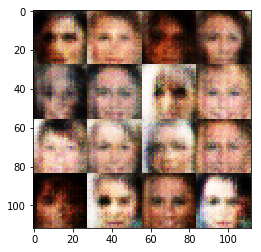

Epoch 1/1... Step 720... Discriminator Loss: 1.4265... Generator Loss: 0.6266
Epoch 1/1... Step 740... Discriminator Loss: 1.4486... Generator Loss: 0.5752
Epoch 1/1... Step 760... Discriminator Loss: 1.5285... Generator Loss: 0.6689
Epoch 1/1... Step 780... Discriminator Loss: 1.5523... Generator Loss: 0.5839
Epoch 1/1... Step 800... Discriminator Loss: 1.4874... Generator Loss: 0.6079


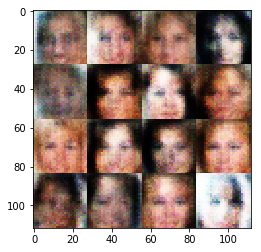

Epoch 1/1... Step 820... Discriminator Loss: 1.5050... Generator Loss: 0.5775
Epoch 1/1... Step 840... Discriminator Loss: 1.4614... Generator Loss: 0.6001
Epoch 1/1... Step 860... Discriminator Loss: 1.4794... Generator Loss: 0.6703
Epoch 1/1... Step 880... Discriminator Loss: 1.4717... Generator Loss: 0.6575
Epoch 1/1... Step 900... Discriminator Loss: 1.4242... Generator Loss: 0.6455


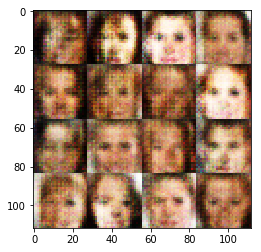

Epoch 1/1... Step 920... Discriminator Loss: 1.5605... Generator Loss: 0.6570
Epoch 1/1... Step 940... Discriminator Loss: 1.4608... Generator Loss: 0.6028
Epoch 1/1... Step 960... Discriminator Loss: 1.4743... Generator Loss: 0.6686
Epoch 1/1... Step 980... Discriminator Loss: 1.5047... Generator Loss: 0.6073
Epoch 1/1... Step 1000... Discriminator Loss: 1.6071... Generator Loss: 0.5729


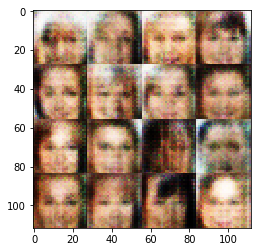

Epoch 1/1... Step 1020... Discriminator Loss: 1.5346... Generator Loss: 0.6781
Epoch 1/1... Step 1040... Discriminator Loss: 1.4861... Generator Loss: 0.5970
Epoch 1/1... Step 1060... Discriminator Loss: 1.4040... Generator Loss: 0.6052
Epoch 1/1... Step 1080... Discriminator Loss: 1.4358... Generator Loss: 0.6301
Epoch 1/1... Step 1100... Discriminator Loss: 1.4250... Generator Loss: 0.6321


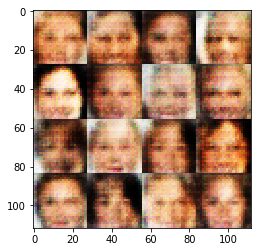

Epoch 1/1... Step 1120... Discriminator Loss: 1.4961... Generator Loss: 0.6450
Epoch 1/1... Step 1140... Discriminator Loss: 1.5193... Generator Loss: 0.6846
Epoch 1/1... Step 1160... Discriminator Loss: 1.4639... Generator Loss: 0.6081
Epoch 1/1... Step 1180... Discriminator Loss: 1.4120... Generator Loss: 0.5841
Epoch 1/1... Step 1200... Discriminator Loss: 1.5509... Generator Loss: 0.5730


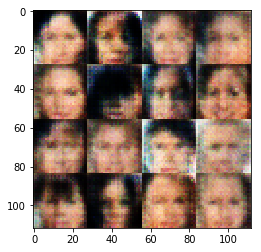

Epoch 1/1... Step 1220... Discriminator Loss: 1.5139... Generator Loss: 0.6636
Epoch 1/1... Step 1240... Discriminator Loss: 1.4924... Generator Loss: 0.6097
Epoch 1/1... Step 1260... Discriminator Loss: 1.4888... Generator Loss: 0.6022
Epoch 1/1... Step 1280... Discriminator Loss: 1.5745... Generator Loss: 0.5689
Epoch 1/1... Step 1300... Discriminator Loss: 1.4701... Generator Loss: 0.5768


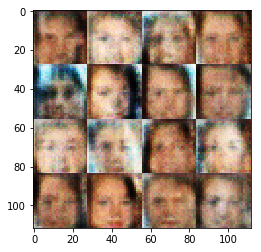

Epoch 1/1... Step 1320... Discriminator Loss: 1.6018... Generator Loss: 0.5406
Epoch 1/1... Step 1340... Discriminator Loss: 1.4986... Generator Loss: 0.5753
Epoch 1/1... Step 1360... Discriminator Loss: 1.4975... Generator Loss: 0.6068
Epoch 1/1... Step 1380... Discriminator Loss: 1.3926... Generator Loss: 0.6445
Epoch 1/1... Step 1400... Discriminator Loss: 1.5138... Generator Loss: 0.6488


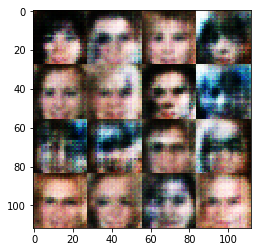

Epoch 1/1... Step 1420... Discriminator Loss: 1.5598... Generator Loss: 0.5865
Epoch 1/1... Step 1440... Discriminator Loss: 1.3869... Generator Loss: 0.6283
Epoch 1/1... Step 1460... Discriminator Loss: 1.4734... Generator Loss: 0.6116
Epoch 1/1... Step 1480... Discriminator Loss: 1.4256... Generator Loss: 0.6714
Epoch 1/1... Step 1500... Discriminator Loss: 1.3761... Generator Loss: 0.6484


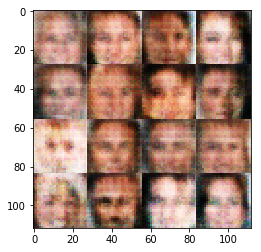

Epoch 1/1... Step 1520... Discriminator Loss: 1.4298... Generator Loss: 0.6493
Epoch 1/1... Step 1540... Discriminator Loss: 1.6289... Generator Loss: 0.5795
Epoch 1/1... Step 1560... Discriminator Loss: 1.4613... Generator Loss: 0.6437
Epoch 1/1... Step 1580... Discriminator Loss: 1.3731... Generator Loss: 0.6389
Epoch 1/1... Step 1600... Discriminator Loss: 1.4964... Generator Loss: 0.5518


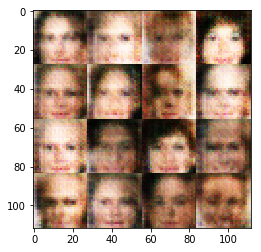

Epoch 1/1... Step 1620... Discriminator Loss: 1.4483... Generator Loss: 0.6284
Epoch 1/1... Step 1640... Discriminator Loss: 1.4872... Generator Loss: 0.6605
Epoch 1/1... Step 1660... Discriminator Loss: 1.4579... Generator Loss: 0.6109
Epoch 1/1... Step 1680... Discriminator Loss: 1.4474... Generator Loss: 0.6289
Epoch 1/1... Step 1700... Discriminator Loss: 1.4083... Generator Loss: 0.6361


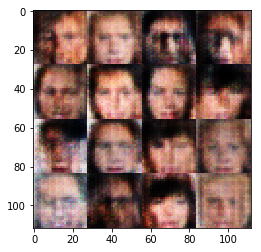

Epoch 1/1... Step 1720... Discriminator Loss: 1.5553... Generator Loss: 0.5672
Epoch 1/1... Step 1740... Discriminator Loss: 1.4826... Generator Loss: 0.7051
Epoch 1/1... Step 1760... Discriminator Loss: 1.4790... Generator Loss: 0.6306
Epoch 1/1... Step 1780... Discriminator Loss: 1.4917... Generator Loss: 0.6113
Epoch 1/1... Step 1800... Discriminator Loss: 1.4769... Generator Loss: 0.6216


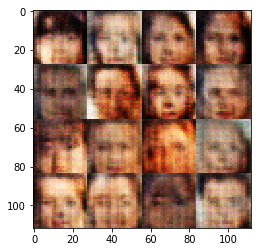

Epoch 1/1... Step 1820... Discriminator Loss: 1.4803... Generator Loss: 0.6994
Epoch 1/1... Step 1840... Discriminator Loss: 1.5062... Generator Loss: 0.6245
Epoch 1/1... Step 1860... Discriminator Loss: 1.4849... Generator Loss: 0.7390
Epoch 1/1... Step 1880... Discriminator Loss: 1.4256... Generator Loss: 0.6619
Epoch 1/1... Step 1900... Discriminator Loss: 1.3886... Generator Loss: 0.6826


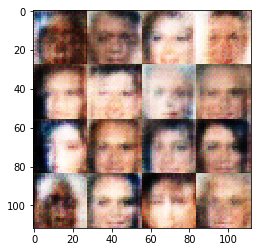

Epoch 1/1... Step 1920... Discriminator Loss: 1.5374... Generator Loss: 0.6313
Epoch 1/1... Step 1940... Discriminator Loss: 1.4254... Generator Loss: 0.6654
Epoch 1/1... Step 1960... Discriminator Loss: 1.4417... Generator Loss: 0.6277
Epoch 1/1... Step 1980... Discriminator Loss: 1.4929... Generator Loss: 0.6277
Epoch 1/1... Step 2000... Discriminator Loss: 1.5691... Generator Loss: 0.6208


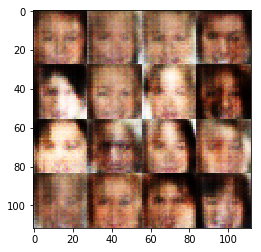

Epoch 1/1... Step 2020... Discriminator Loss: 1.4316... Generator Loss: 0.6362
Epoch 1/1... Step 2040... Discriminator Loss: 1.5375... Generator Loss: 0.5762
Epoch 1/1... Step 2060... Discriminator Loss: 1.4989... Generator Loss: 0.6410
Epoch 1/1... Step 2080... Discriminator Loss: 1.4119... Generator Loss: 0.6270
Epoch 1/1... Step 2100... Discriminator Loss: 1.4895... Generator Loss: 0.5996


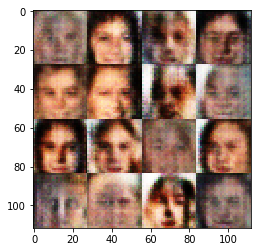

Epoch 1/1... Step 2120... Discriminator Loss: 1.4289... Generator Loss: 0.6441
Epoch 1/1... Step 2140... Discriminator Loss: 1.4474... Generator Loss: 0.6798
Epoch 1/1... Step 2160... Discriminator Loss: 1.5248... Generator Loss: 0.6572
Epoch 1/1... Step 2180... Discriminator Loss: 1.4831... Generator Loss: 0.6110
Epoch 1/1... Step 2200... Discriminator Loss: 1.4214... Generator Loss: 0.6471


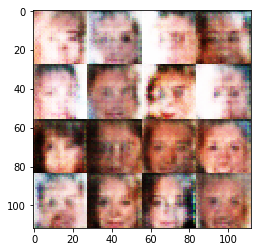

Epoch 1/1... Step 2220... Discriminator Loss: 1.4509... Generator Loss: 0.6524
Epoch 1/1... Step 2240... Discriminator Loss: 1.4201... Generator Loss: 0.6273
Epoch 1/1... Step 2260... Discriminator Loss: 1.4342... Generator Loss: 0.6425
Epoch 1/1... Step 2280... Discriminator Loss: 1.5639... Generator Loss: 0.6043
Epoch 1/1... Step 2300... Discriminator Loss: 1.4472... Generator Loss: 0.6176


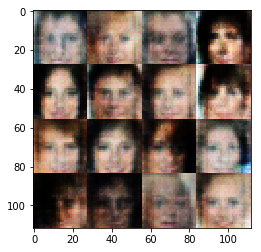

Epoch 1/1... Step 2320... Discriminator Loss: 1.4888... Generator Loss: 0.5363
Epoch 1/1... Step 2340... Discriminator Loss: 1.4009... Generator Loss: 0.7315
Epoch 1/1... Step 2360... Discriminator Loss: 1.3913... Generator Loss: 0.6256
Epoch 1/1... Step 2380... Discriminator Loss: 1.4606... Generator Loss: 0.6495
Epoch 1/1... Step 2400... Discriminator Loss: 1.4600... Generator Loss: 0.6643


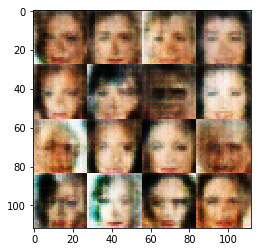

Epoch 1/1... Step 2420... Discriminator Loss: 1.4309... Generator Loss: 0.6506
Epoch 1/1... Step 2440... Discriminator Loss: 1.4190... Generator Loss: 0.6645
Epoch 1/1... Step 2460... Discriminator Loss: 1.4102... Generator Loss: 0.7022
Epoch 1/1... Step 2480... Discriminator Loss: 1.4675... Generator Loss: 0.6198
Epoch 1/1... Step 2500... Discriminator Loss: 1.5215... Generator Loss: 0.6261


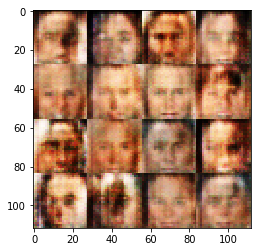

Epoch 1/1... Step 2520... Discriminator Loss: 1.4974... Generator Loss: 0.5965
Epoch 1/1... Step 2540... Discriminator Loss: 1.4419... Generator Loss: 0.6397
Epoch 1/1... Step 2560... Discriminator Loss: 1.4089... Generator Loss: 0.7119
Epoch 1/1... Step 2580... Discriminator Loss: 1.4802... Generator Loss: 0.6127
Epoch 1/1... Step 2600... Discriminator Loss: 1.4635... Generator Loss: 0.6273


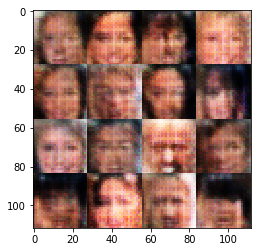

Epoch 1/1... Step 2620... Discriminator Loss: 1.5018... Generator Loss: 0.6343
Epoch 1/1... Step 2640... Discriminator Loss: 1.4814... Generator Loss: 0.6038
Epoch 1/1... Step 2660... Discriminator Loss: 1.4312... Generator Loss: 0.6495
Epoch 1/1... Step 2680... Discriminator Loss: 1.5372... Generator Loss: 0.5726
Epoch 1/1... Step 2700... Discriminator Loss: 1.5080... Generator Loss: 0.5685


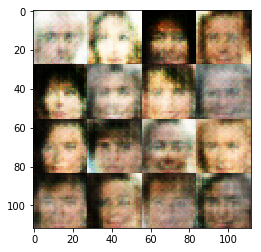

Epoch 1/1... Step 2720... Discriminator Loss: 1.5336... Generator Loss: 0.6261
Epoch 1/1... Step 2740... Discriminator Loss: 1.4687... Generator Loss: 0.6521
Epoch 1/1... Step 2760... Discriminator Loss: 1.5714... Generator Loss: 0.5627
Epoch 1/1... Step 2780... Discriminator Loss: 1.4621... Generator Loss: 0.6564
Epoch 1/1... Step 2800... Discriminator Loss: 1.4718... Generator Loss: 0.6750


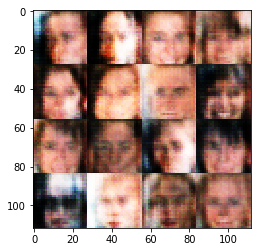

Epoch 1/1... Step 2820... Discriminator Loss: 1.4143... Generator Loss: 0.6620
Epoch 1/1... Step 2840... Discriminator Loss: 1.4348... Generator Loss: 0.6645
Epoch 1/1... Step 2860... Discriminator Loss: 1.4199... Generator Loss: 0.6646
Epoch 1/1... Step 2880... Discriminator Loss: 1.4282... Generator Loss: 0.6765
Epoch 1/1... Step 2900... Discriminator Loss: 1.5070... Generator Loss: 0.5371


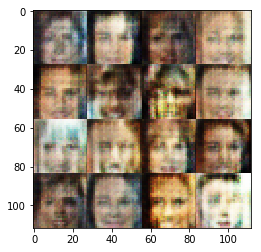

Epoch 1/1... Step 2920... Discriminator Loss: 1.4044... Generator Loss: 0.6945
Epoch 1/1... Step 2940... Discriminator Loss: 1.4536... Generator Loss: 0.6289
Epoch 1/1... Step 2960... Discriminator Loss: 1.4649... Generator Loss: 0.6036
Epoch 1/1... Step 2980... Discriminator Loss: 1.4096... Generator Loss: 0.6165
Epoch 1/1... Step 3000... Discriminator Loss: 1.4539... Generator Loss: 0.6493


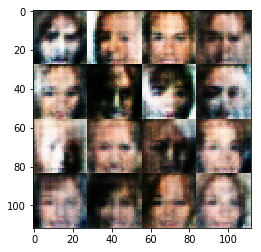

Epoch 1/1... Step 3020... Discriminator Loss: 1.4683... Generator Loss: 0.7027
Epoch 1/1... Step 3040... Discriminator Loss: 1.4299... Generator Loss: 0.6196
Epoch 1/1... Step 3060... Discriminator Loss: 1.4311... Generator Loss: 0.6071
Epoch 1/1... Step 3080... Discriminator Loss: 1.4616... Generator Loss: 0.6505
Epoch 1/1... Step 3100... Discriminator Loss: 1.4835... Generator Loss: 0.6249


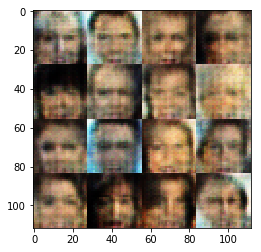

Epoch 1/1... Step 3120... Discriminator Loss: 1.5137... Generator Loss: 0.6088
Epoch 1/1... Step 3140... Discriminator Loss: 1.4323... Generator Loss: 0.6255
Epoch 1/1... Step 3160... Discriminator Loss: 1.4234... Generator Loss: 0.6887
Epoch 1/1... Step 3180... Discriminator Loss: 1.4410... Generator Loss: 0.6355
Epoch 1/1... Step 3200... Discriminator Loss: 1.4837... Generator Loss: 0.6170


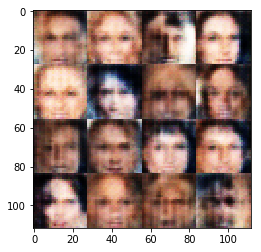

Epoch 1/1... Step 3220... Discriminator Loss: 1.4146... Generator Loss: 0.6952
Epoch 1/1... Step 3240... Discriminator Loss: 1.4999... Generator Loss: 0.6728
Epoch 1/1... Step 3260... Discriminator Loss: 1.3552... Generator Loss: 0.6854
Epoch 1/1... Step 3280... Discriminator Loss: 1.4208... Generator Loss: 0.6740
Epoch 1/1... Step 3300... Discriminator Loss: 1.5693... Generator Loss: 0.6243


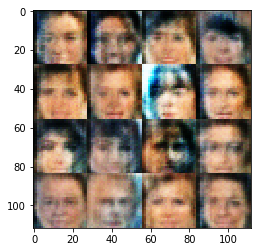

Epoch 1/1... Step 3320... Discriminator Loss: 1.4484... Generator Loss: 0.6405
Epoch 1/1... Step 3340... Discriminator Loss: 1.4235... Generator Loss: 0.7121
Epoch 1/1... Step 3360... Discriminator Loss: 1.4134... Generator Loss: 0.6502
Epoch 1/1... Step 3380... Discriminator Loss: 1.4213... Generator Loss: 0.6781
Epoch 1/1... Step 3400... Discriminator Loss: 1.4621... Generator Loss: 0.6939


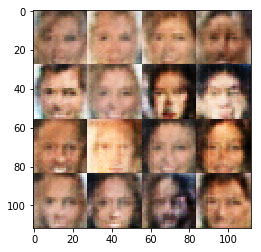

Epoch 1/1... Step 3420... Discriminator Loss: 1.4355... Generator Loss: 0.6549
Epoch 1/1... Step 3440... Discriminator Loss: 1.4422... Generator Loss: 0.6470
Epoch 1/1... Step 3460... Discriminator Loss: 1.5100... Generator Loss: 0.6691
Epoch 1/1... Step 3480... Discriminator Loss: 1.4918... Generator Loss: 0.6384
Epoch 1/1... Step 3500... Discriminator Loss: 1.3967... Generator Loss: 0.6149


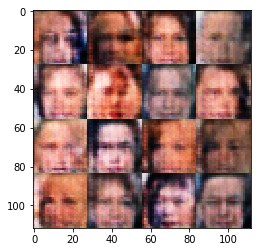

Epoch 1/1... Step 3520... Discriminator Loss: 1.4933... Generator Loss: 0.5953
Epoch 1/1... Step 3540... Discriminator Loss: 1.4639... Generator Loss: 0.6546
Epoch 1/1... Step 3560... Discriminator Loss: 1.4187... Generator Loss: 0.6131
Epoch 1/1... Step 3580... Discriminator Loss: 1.4430... Generator Loss: 0.6863
Epoch 1/1... Step 3600... Discriminator Loss: 1.4811... Generator Loss: 0.5806


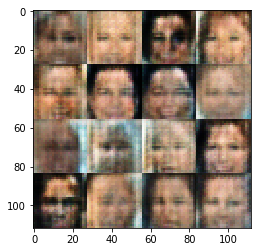

Epoch 1/1... Step 3620... Discriminator Loss: 1.4544... Generator Loss: 0.6206
Epoch 1/1... Step 3640... Discriminator Loss: 1.4350... Generator Loss: 0.6512
Epoch 1/1... Step 3660... Discriminator Loss: 1.5190... Generator Loss: 0.5599
Epoch 1/1... Step 3680... Discriminator Loss: 1.4500... Generator Loss: 0.6809
Epoch 1/1... Step 3700... Discriminator Loss: 1.4334... Generator Loss: 0.6429


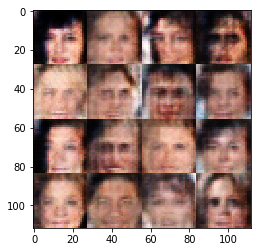

Epoch 1/1... Step 3720... Discriminator Loss: 1.4349... Generator Loss: 0.6438
Epoch 1/1... Step 3740... Discriminator Loss: 1.4722... Generator Loss: 0.6166
Epoch 1/1... Step 3760... Discriminator Loss: 1.4702... Generator Loss: 0.6539
Epoch 1/1... Step 3780... Discriminator Loss: 1.4219... Generator Loss: 0.6877
Epoch 1/1... Step 3800... Discriminator Loss: 1.4030... Generator Loss: 0.6502


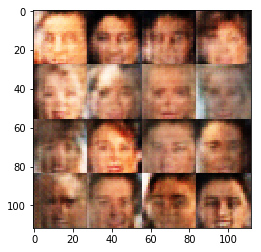

Epoch 1/1... Step 3820... Discriminator Loss: 1.4532... Generator Loss: 0.6504
Epoch 1/1... Step 3840... Discriminator Loss: 1.4226... Generator Loss: 0.6473
Epoch 1/1... Step 3860... Discriminator Loss: 1.4187... Generator Loss: 0.6419
Epoch 1/1... Step 3880... Discriminator Loss: 1.5045... Generator Loss: 0.6432
Epoch 1/1... Step 3900... Discriminator Loss: 1.4509... Generator Loss: 0.6436


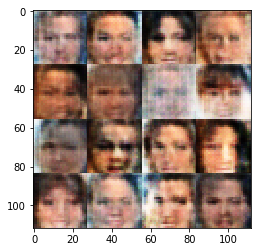

Epoch 1/1... Step 3920... Discriminator Loss: 1.4640... Generator Loss: 0.6736
Epoch 1/1... Step 3940... Discriminator Loss: 1.4036... Generator Loss: 0.6365
Epoch 1/1... Step 3960... Discriminator Loss: 1.4439... Generator Loss: 0.6482
Epoch 1/1... Step 3980... Discriminator Loss: 1.4241... Generator Loss: 0.6391
Epoch 1/1... Step 4000... Discriminator Loss: 1.4119... Generator Loss: 0.6043


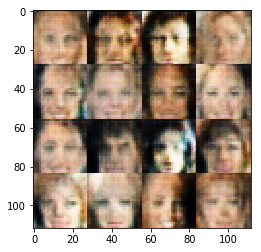

Epoch 1/1... Step 4020... Discriminator Loss: 1.4394... Generator Loss: 0.6496
Epoch 1/1... Step 4040... Discriminator Loss: 1.4492... Generator Loss: 0.6912
Epoch 1/1... Step 4060... Discriminator Loss: 1.4262... Generator Loss: 0.6411
Epoch 1/1... Step 4080... Discriminator Loss: 1.4471... Generator Loss: 0.6364
Epoch 1/1... Step 4100... Discriminator Loss: 1.4187... Generator Loss: 0.6882


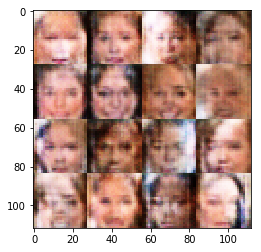

Epoch 1/1... Step 4120... Discriminator Loss: 1.4927... Generator Loss: 0.6368
Epoch 1/1... Step 4140... Discriminator Loss: 1.4658... Generator Loss: 0.5967
Epoch 1/1... Step 4160... Discriminator Loss: 1.4128... Generator Loss: 0.7634
Epoch 1/1... Step 4180... Discriminator Loss: 1.4662... Generator Loss: 0.6161
Epoch 1/1... Step 4200... Discriminator Loss: 1.4092... Generator Loss: 0.6599


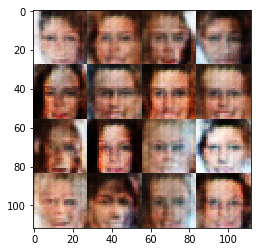

Epoch 1/1... Step 4220... Discriminator Loss: 1.4217... Generator Loss: 0.6404
Epoch 1/1... Step 4240... Discriminator Loss: 1.4228... Generator Loss: 0.6779
Epoch 1/1... Step 4260... Discriminator Loss: 1.4560... Generator Loss: 0.7085
Epoch 1/1... Step 4280... Discriminator Loss: 1.4224... Generator Loss: 0.7002
Epoch 1/1... Step 4300... Discriminator Loss: 1.4596... Generator Loss: 0.6173


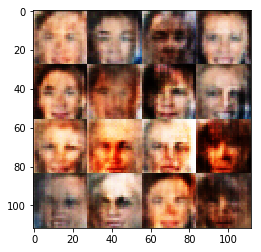

Epoch 1/1... Step 4320... Discriminator Loss: 1.4548... Generator Loss: 0.6304
Epoch 1/1... Step 4340... Discriminator Loss: 1.4880... Generator Loss: 0.5991
Epoch 1/1... Step 4360... Discriminator Loss: 1.3702... Generator Loss: 0.7376
Epoch 1/1... Step 4380... Discriminator Loss: 1.4922... Generator Loss: 0.6569
Epoch 1/1... Step 4400... Discriminator Loss: 1.4640... Generator Loss: 0.6435


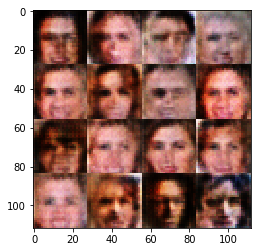

Epoch 1/1... Step 4420... Discriminator Loss: 1.5164... Generator Loss: 0.6631
Epoch 1/1... Step 4440... Discriminator Loss: 1.3811... Generator Loss: 0.6802
Epoch 1/1... Step 4460... Discriminator Loss: 1.3913... Generator Loss: 0.6312
Epoch 1/1... Step 4480... Discriminator Loss: 1.4303... Generator Loss: 0.6758
Epoch 1/1... Step 4500... Discriminator Loss: 1.4253... Generator Loss: 0.6431


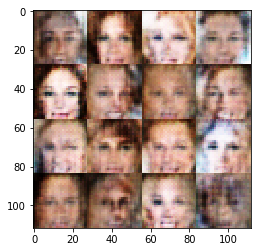

Epoch 1/1... Step 4520... Discriminator Loss: 1.4144... Generator Loss: 0.6412
Epoch 1/1... Step 4540... Discriminator Loss: 1.4299... Generator Loss: 0.6842
Epoch 1/1... Step 4560... Discriminator Loss: 1.4136... Generator Loss: 0.6501
Epoch 1/1... Step 4580... Discriminator Loss: 1.4232... Generator Loss: 0.6946
Epoch 1/1... Step 4600... Discriminator Loss: 1.4069... Generator Loss: 0.6804


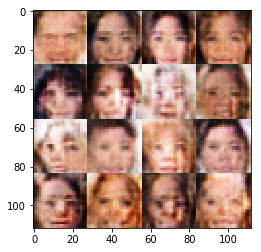

Epoch 1/1... Step 4620... Discriminator Loss: 1.4810... Generator Loss: 0.6868
Epoch 1/1... Step 4640... Discriminator Loss: 1.4184... Generator Loss: 0.6391
Epoch 1/1... Step 4660... Discriminator Loss: 1.4006... Generator Loss: 0.6831
Epoch 1/1... Step 4680... Discriminator Loss: 1.3687... Generator Loss: 0.6648
Epoch 1/1... Step 4700... Discriminator Loss: 1.4346... Generator Loss: 0.7088


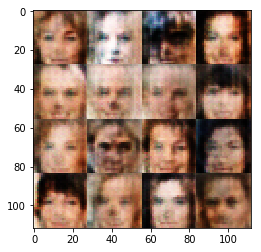

Epoch 1/1... Step 4720... Discriminator Loss: 1.4575... Generator Loss: 0.6343
Epoch 1/1... Step 4740... Discriminator Loss: 1.4239... Generator Loss: 0.6278
Epoch 1/1... Step 4760... Discriminator Loss: 1.4289... Generator Loss: 0.6468
Epoch 1/1... Step 4780... Discriminator Loss: 1.4137... Generator Loss: 0.7178
Epoch 1/1... Step 4800... Discriminator Loss: 1.4358... Generator Loss: 0.6736


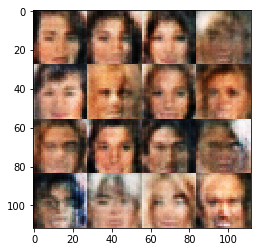

Epoch 1/1... Step 4820... Discriminator Loss: 1.4664... Generator Loss: 0.6640
Epoch 1/1... Step 4840... Discriminator Loss: 1.4055... Generator Loss: 0.6535
Epoch 1/1... Step 4860... Discriminator Loss: 1.4303... Generator Loss: 0.6776
Epoch 1/1... Step 4880... Discriminator Loss: 1.4924... Generator Loss: 0.6234
Epoch 1/1... Step 4900... Discriminator Loss: 1.4305... Generator Loss: 0.6721


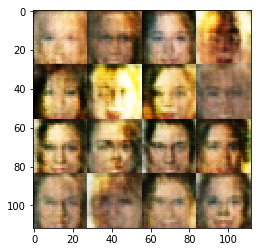

Epoch 1/1... Step 4920... Discriminator Loss: 1.4597... Generator Loss: 0.5905
Epoch 1/1... Step 4940... Discriminator Loss: 1.4480... Generator Loss: 0.6983
Epoch 1/1... Step 4960... Discriminator Loss: 1.4088... Generator Loss: 0.6609
Epoch 1/1... Step 4980... Discriminator Loss: 1.3955... Generator Loss: 0.6779
Epoch 1/1... Step 5000... Discriminator Loss: 1.4550... Generator Loss: 0.6436


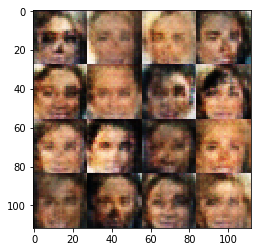

Epoch 1/1... Step 5020... Discriminator Loss: 1.4380... Generator Loss: 0.6482
Epoch 1/1... Step 5040... Discriminator Loss: 1.4797... Generator Loss: 0.6296
Epoch 1/1... Step 5060... Discriminator Loss: 1.4291... Generator Loss: 0.6947
Epoch 1/1... Step 5080... Discriminator Loss: 1.4359... Generator Loss: 0.6603
Epoch 1/1... Step 5100... Discriminator Loss: 1.3860... Generator Loss: 0.7285


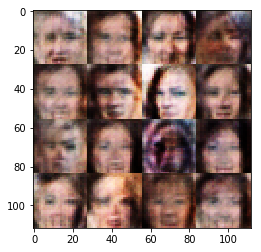

Epoch 1/1... Step 5120... Discriminator Loss: 1.3969... Generator Loss: 0.6838
Epoch 1/1... Step 5140... Discriminator Loss: 1.4765... Generator Loss: 0.6479
Epoch 1/1... Step 5160... Discriminator Loss: 1.4123... Generator Loss: 0.7026
Epoch 1/1... Step 5180... Discriminator Loss: 1.4259... Generator Loss: 0.6810
Epoch 1/1... Step 5200... Discriminator Loss: 1.4593... Generator Loss: 0.6180


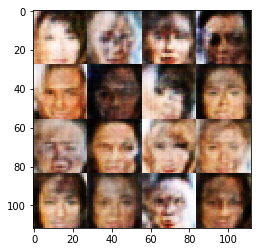

Epoch 1/1... Step 5220... Discriminator Loss: 1.4078... Generator Loss: 0.6958
Epoch 1/1... Step 5240... Discriminator Loss: 1.4490... Generator Loss: 0.6666
Epoch 1/1... Step 5260... Discriminator Loss: 1.4810... Generator Loss: 0.6086
Epoch 1/1... Step 5280... Discriminator Loss: 1.4048... Generator Loss: 0.6167
Epoch 1/1... Step 5300... Discriminator Loss: 1.4311... Generator Loss: 0.6611


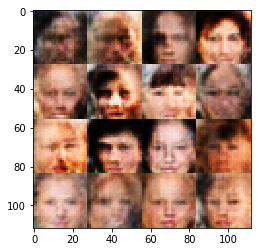

Epoch 1/1... Step 5320... Discriminator Loss: 1.3952... Generator Loss: 0.6820
Epoch 1/1... Step 5340... Discriminator Loss: 1.4228... Generator Loss: 0.6779
Epoch 1/1... Step 5360... Discriminator Loss: 1.4170... Generator Loss: 0.6816
Epoch 1/1... Step 5380... Discriminator Loss: 1.4485... Generator Loss: 0.6407
Epoch 1/1... Step 5400... Discriminator Loss: 1.4200... Generator Loss: 0.6489


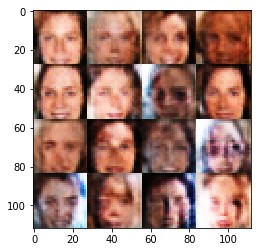

Epoch 1/1... Step 5420... Discriminator Loss: 1.3809... Generator Loss: 0.6631
Epoch 1/1... Step 5440... Discriminator Loss: 1.4480... Generator Loss: 0.6398
Epoch 1/1... Step 5460... Discriminator Loss: 1.3719... Generator Loss: 0.7168
Epoch 1/1... Step 5480... Discriminator Loss: 1.4235... Generator Loss: 0.6216
Epoch 1/1... Step 5500... Discriminator Loss: 1.3995... Generator Loss: 0.6319


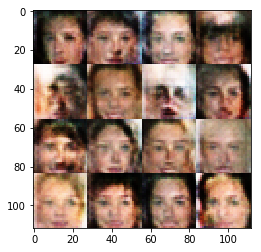

Epoch 1/1... Step 5520... Discriminator Loss: 1.4057... Generator Loss: 0.6914
Epoch 1/1... Step 5540... Discriminator Loss: 1.4379... Generator Loss: 0.6142
Epoch 1/1... Step 5560... Discriminator Loss: 1.4205... Generator Loss: 0.6756
Epoch 1/1... Step 5580... Discriminator Loss: 1.4697... Generator Loss: 0.6252
Epoch 1/1... Step 5600... Discriminator Loss: 1.4124... Generator Loss: 0.7061


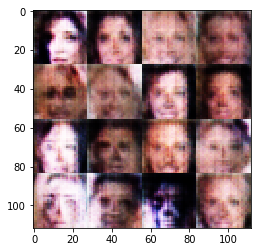

Epoch 1/1... Step 5620... Discriminator Loss: 1.4392... Generator Loss: 0.6077
Epoch 1/1... Step 5640... Discriminator Loss: 1.4030... Generator Loss: 0.7399
Epoch 1/1... Step 5660... Discriminator Loss: 1.4136... Generator Loss: 0.6840
Epoch 1/1... Step 5680... Discriminator Loss: 1.4245... Generator Loss: 0.6557
Epoch 1/1... Step 5700... Discriminator Loss: 1.4131... Generator Loss: 0.7192


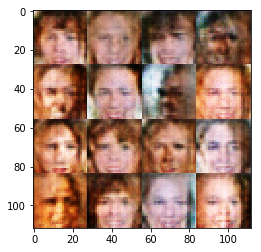

Epoch 1/1... Step 5720... Discriminator Loss: 1.4035... Generator Loss: 0.6789
Epoch 1/1... Step 5740... Discriminator Loss: 1.4241... Generator Loss: 0.6961
Epoch 1/1... Step 5760... Discriminator Loss: 1.4868... Generator Loss: 0.6297
Epoch 1/1... Step 5780... Discriminator Loss: 1.3922... Generator Loss: 0.6310
Epoch 1/1... Step 5800... Discriminator Loss: 1.4248... Generator Loss: 0.7098


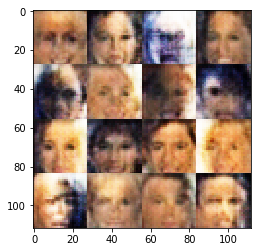

Epoch 1/1... Step 5820... Discriminator Loss: 1.3535... Generator Loss: 0.6854
Epoch 1/1... Step 5840... Discriminator Loss: 1.4437... Generator Loss: 0.6268
Epoch 1/1... Step 5860... Discriminator Loss: 1.4346... Generator Loss: 0.6207
Epoch 1/1... Step 5880... Discriminator Loss: 1.3901... Generator Loss: 0.6619
Epoch 1/1... Step 5900... Discriminator Loss: 1.4474... Generator Loss: 0.6708


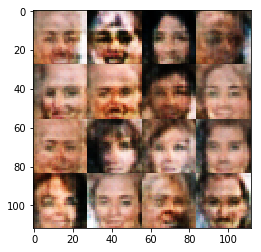

Epoch 1/1... Step 5920... Discriminator Loss: 1.4241... Generator Loss: 0.6459
Epoch 1/1... Step 5940... Discriminator Loss: 1.4287... Generator Loss: 0.6561
Epoch 1/1... Step 5960... Discriminator Loss: 1.4872... Generator Loss: 0.6429
Epoch 1/1... Step 5980... Discriminator Loss: 1.4209... Generator Loss: 0.6617
Epoch 1/1... Step 6000... Discriminator Loss: 1.4333... Generator Loss: 0.6470


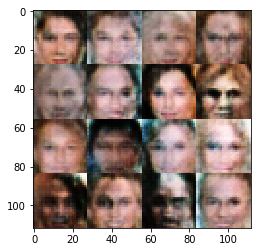

Epoch 1/1... Step 6020... Discriminator Loss: 1.4214... Generator Loss: 0.6163
Epoch 1/1... Step 6040... Discriminator Loss: 1.3968... Generator Loss: 0.6979
Epoch 1/1... Step 6060... Discriminator Loss: 1.4183... Generator Loss: 0.6736
Epoch 1/1... Step 6080... Discriminator Loss: 1.4273... Generator Loss: 0.6680
Epoch 1/1... Step 6100... Discriminator Loss: 1.3678... Generator Loss: 0.6870


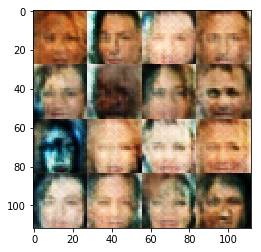

Epoch 1/1... Step 6120... Discriminator Loss: 1.4326... Generator Loss: 0.6549
Epoch 1/1... Step 6140... Discriminator Loss: 1.4394... Generator Loss: 0.6862
Epoch 1/1... Step 6160... Discriminator Loss: 1.4174... Generator Loss: 0.6288
Epoch 1/1... Step 6180... Discriminator Loss: 1.4663... Generator Loss: 0.6756
Epoch 1/1... Step 6200... Discriminator Loss: 1.4443... Generator Loss: 0.6012


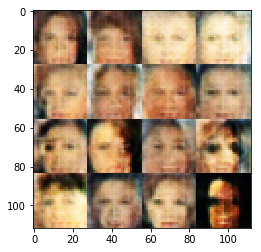

Epoch 1/1... Step 6220... Discriminator Loss: 1.4290... Generator Loss: 0.7105
Epoch 1/1... Step 6240... Discriminator Loss: 1.4024... Generator Loss: 0.6654
Epoch 1/1... Step 6260... Discriminator Loss: 1.3893... Generator Loss: 0.6330
Epoch 1/1... Step 6280... Discriminator Loss: 1.4164... Generator Loss: 0.6500
Epoch 1/1... Step 6300... Discriminator Loss: 1.4799... Generator Loss: 0.6247


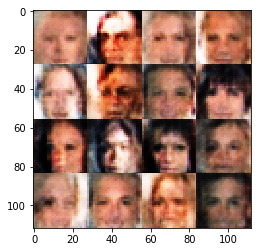

Epoch 1/1... Step 6320... Discriminator Loss: 1.4163... Generator Loss: 0.7070


IndexError: list index out of range

In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.